In [1]:
import os
base=os.path.dirname(os.path.realpath("__file__")).split(os.sep)
os.chdir(os.sep+os.path.join(*base[:-1]))
os.getcwd()

'/Users/haihabi/projects/NormFlowPy'

In [2]:
import numpy as np
import normflowpy as nfp
import torch
from matplotlib import pyplot as plt
from torch.distributions import MultivariateNormal
from experiments.functions import run_training
from experiments.datasets.preprocess import Dequatization
from torchvision import  transforms
import torchvision

/Users/haihabi/Envs/research_3_7/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/haihabi/Envs/research_3_7/lib/python3.7/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: /Users/haihabi/Envs/research_3_7/lib/python3.7/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 14.0.0 or later, but libjpeg.9.dylib provides version 12.0.0
  warn(f"Failed to load image Python extension: {e}")


In [3]:
n_flow_blocks = 3
batch_size = 32
n_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Working Device is set to:" + str(device))
transform=transforms.Compose([
        transforms.ToTensor(),
        Dequatization()
        ])

def collater(batch):
    return torch.stack([b[0] for b in batch],dim=0)




training_data=torchvision.datasets.MNIST('data', train=True, download=True,
                       transform=transform)
training_dataset_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                                      shuffle=True, num_workers=0,collate_fn=collater)
validation_data=torchvision.datasets.MNIST('data', train=False, download=True,
                       transform=transform)
validation_dataset_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                                        shuffle=False, num_workers=0,collate_fn=collater)

Current Working Device is set to:cpu


  5%|▍         | 494592/9912422 [00:04<01:10, 133144.10it/s]

# Create Glow Normalizing Flow Model

In [ ]:
x_shape=[1,28,28]
dim=np.prod(x_shape)
base_distribution = MultivariateNormal(torch.zeros(dim, device=device),
                                       torch.eye(dim, device=device))  # generate a class for base distribution
flows = []
for s in range(2):
    x_shape=[x_shape[0]*4,x_shape[1]//2,x_shape[2]//2]
    flows.append(nfp.flows.Squeeze(2))
    for i in range(n_flow_blocks):
        flows.append(
            nfp.flows.ActNorm(x_shape=x_shape))
        flows.append(
            nfp.flows.InvertibleConv2d1x1(dim=x_shape[0]))
        flows.append(
            nfp.flows.AffineCoupling(x_shape=x_shape, parity=i % 2,  nh=32))
flows.append(nfp.flows.Tensor2Vector(x_shape))
flow = nfp.NormalizingFlowModel(base_distribution, flows).to(device)

# Set Optimizer and run training

In [ ]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3,weight_decay=1e-4)
run_training(n_epochs, training_dataset_loader, validation_dataset_loader, flow, optimizer, device)

Starting Training Loop


End Epoch with training loss:127015.66297521922 and validtion loss:7281.986563051852
End Epoch with training loss:3834.792425520833 and validtion loss:2820.8307573726765
End Epoch with training loss:1272.278626546224 and validtion loss:12675.879638848593
End Epoch with training loss:521.8216703979492 and validtion loss:63358.880317954594
End Epoch with training loss:222.58501174112956 and validtion loss:149338.550518003
End Epoch with training loss:92.85980861867269 and validtion loss:126448.5019971804
End Epoch with training loss:36.88964098587036 and validtion loss:72228.79285460897
End Epoch with training loss:14.623312777968248 and validtion loss:24951.113680655213
End Epoch with training loss:3.8107240659156814 and validtion loss:4520.754283976613
End Epoch with training loss:-0.3819766155144821 and validtion loss:2947.6271228422156
End Epoch with training loss:-2.5830483684482672 and validtion loss:2863.4007782890394
End Epoch with training loss:-3.6518241638183593 and validtion 

# Plot Samples

In [ ]:
img=flow.sample(32)

4.02893 -0.8974374
1.3258936 -0.28664196
12.771264 -10.106139
17.621904 -9.541475
24.421509 -4.098285
28.95105 -5.132152
18.851128 -15.614518
7.0425453 -1.5705204
2.213815 -0.8748774
78.60389 -40.2431
181.37299 -64.80293
1.3819691 -0.7597503
1.8991113 -0.28496292
16.400253 -62.521122
4.307445 -1.4998772
36.58819 -3.610413


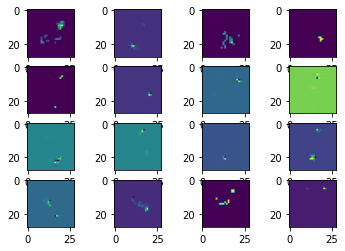

In [ ]:
n = 4
for i in range(n):
    for j in range(n):
        index = i + n * j
        plt.subplot(n, n, 1 + index)
        x=img[index,0,:,:].detach().numpy()
        # print(np.max(x),np.min(x))
        plt.imshow(x.astype("int"))
plt.show()
